### This demo shows an example of loading single cell data processing followed by running RVAgene on the same.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import scanpy
import anndata
from matplotlib.colors import rgb2hex
import os
from random import randint 
import sys
import math

#### Load Data and compute pseudotime

In [6]:
lines=open("./esc_data/gse/GSM1599494_ES_d0_main.csv","r").readlines()
lines2 = open("./esc_data/gse/GSM1599497_ES_d2_LIFminus.csv","r").readlines()
lines4 = open("./esc_data/gse/GSM1599498_ES_d4_LIFminus.csv","r").readlines()
lines7 = open("./esc_data/gse/GSM1599499_ES_d7_LIFminus.csv","r").readlines()

print(len(lines),len(lines2),len(lines4),len(lines7))

24175 24175 24175 24175


In [7]:
exp = []
gene_names = []

for line in range(len(lines)):
    l = lines[line].replace("\n","").split(",")
    l2 = lines2[line].replace("\n","").split(",")
    l4 = lines4[line].replace("\n","").split(",")
    l7 = lines7[line].replace("\n","").split(",")
    gene_names.append(l[0])
    exp.append(np.array([float(i) for i in l[1:]]+ [float(i) for i in l2[1:]] + [float(i) for i in l4[1:]] + [float(i) for i in l7[1:]]))

exp = np.array(exp)

In [8]:
cols = ['r']*(len(l)-1) + ['g']*(len(l2)-1) + ['b']*(len(l4)-1) + ['c']*(len(l7)-1)

In [13]:
degenes = open("./esc_data/degenes_ES2.txt","r").read().split("\n")[:-1]

degene_indices = [gene_names.index(i) for i in degenes]
exp = exp[degene_indices,:]

In [20]:
mat = exp

print("Ordering the cells...")


argmax = np.argmax(np.sum(exp,axis=1))
argmax=451
print(argmax)

marker= degenes[index]

adata = anndata.AnnData(mat.T)
scanpy.pp.neighbors(adata,use_rep='X')
adata.uns
root_cell_index = 1
adata.uns['iroot'] = root_cell_index
print(adata.uns)
diff_vals = scanpy.tl.diffmap(adata,n_comps=10)
print(adata.obsm)
output = scanpy.tl.dpt(adata)
#order cells by pseudotimeall
pseudotime = adata.obs['dpt_pseudotime']


Ordering the cells...
451
OverloadedDict, wrapping:
	OrderedDict([('neighbors', {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'metric': 'euclidean', 'use_rep': 'X'}}), ('iroot', 1)])
With overloaded keys:
	['neighbors'].
AxisArrays with keys: X_diffmap


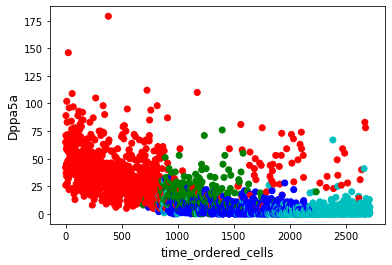

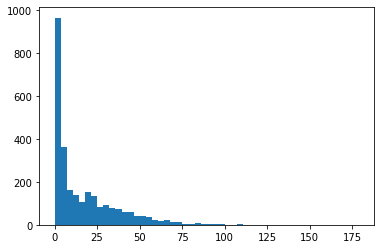

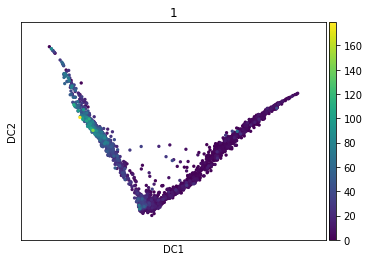

In [22]:
mat = exp
time_ordered_cells = np.argsort(pseudotime)
pseudotime = np.array([i for i in pseudotime])
time_ordered_cells = np.array([i for i in time_ordered_cells])
time_col = np.array(cols)[time_ordered_cells]

### plot some gene in time order
marker = 'Dppa5a'
index = degenes.index(marker)
geneid = index
plt.scatter(range(0,len(time_ordered_cells)), mat[geneid,:][time_ordered_cells],color=time_col)

#plt.scatter(pseudotime[time_ordered_cells], mat[geneid,:][time_ordered_cells],color=time_color)
plt.ylabel(degenes[geneid],fontsize = 12)
plt.xlabel("time_ordered_cells",fontsize = 12)
plt.savefig("drop_ES_pseudotime_" +marker+ ".png",dpi = 500)
plt.show()
plt.close()

plt.hist(exp[geneid,:],bins=50)
plt.show()
plt.close()

scanpy.pl.diffmap(adata,color=str(index))

### Average over windows to reduce noise

In [23]:
window_length = 40
smoothed_exp = []
for gene in tqdm(range(exp.shape[0])):
    gene_smoothed_exp = []
    for n in range(1,exp.shape[1]//window_length+2):
        time_ordered_exp = exp[gene][time_ordered_cells]
        gene_smoothed_exp.append(np.mean(time_ordered_exp[(n-1)*window_length:n*window_length]))
    smoothed_exp.append(gene_smoothed_exp)
smoothed_time_ordered_exp = np.array(smoothed_exp)
print(smoothed_time_ordered_exp.shape)

100%|██████████| 732/732 [00:00<00:00, 1482.67it/s]

(732, 68)


100%|██████████| 732/732 [00:00<00:00, 9505.36it/s]


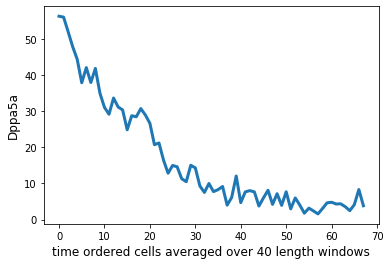

In [24]:
row_sums = smoothed_time_ordered_exp.sum(axis=1) + 0.000000001
#mat = smoothed_time_ordered_exp/ row_sums[:, np.newaxis]  ## normalize, if needed
mat = smoothed_time_ordered_exp

all_corrcoef = []

for gene in tqdm(range(len(degenes))):
    all_corrcoef.append(np.corrcoef(range(mat.shape[1]), mat[gene,:])[0, 1])

plt.plot(range(0,mat.shape[1]), mat[geneid,:],linewidth=3)
plt.ylabel(degenes[geneid],fontsize = 12)
plt.xlabel("time ordered cells averaged over 40 length windows",fontsize = 12)
plt.show()

### Pearson correlation coefficent calculation

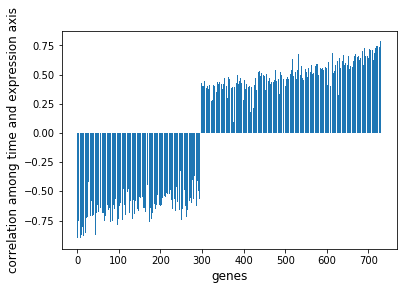

In [26]:
plt.bar(range(0,len(all_corrcoef)),all_corrcoef)
plt.xlabel("genes",fontsize=12)
plt.ylabel("correlation among time and expression axis",fontsize=12)
plt.show()

### prepare and write data for RVAgene

In [27]:
selected_genes = degenes
cols = []
corr_info = []
toplot = []
lines=[]
for gene in range(len(degenes)):
    if(all_corrcoef[gene] >= 0):
        label = "1,"  ## used for annotation, not used in training
        cols.append("r")
        corr_info.append(degenes[gene] + ","+label + str(all_corrcoef[gene]))
        toplot.append(all_corrcoef[gene])
    elif(all_corrcoef[gene] < 0 ):
        label = "2," ## used for annotation, not used in training
        cols.append("b")
        corr_info.append(degenes[gene] + ","+label + str(all_corrcoef[gene]))
        toplot.append(all_corrcoef[gene])

    else:
        print(all_corrcoef[gene],degenes[gene],gene)
        continue
    lines.append(label+",".join([str(i) for i in mat[gene,:].tolist()]))

len(lines)

732

In [29]:
dataset = "ESC"
if(not os.path.exists("./data/"+dataset)):
    os.mkdir("./data/"+dataset)

rnn_input = open("./data/" + dataset + "/"+ dataset + "_TRAIN","w")

rnn_input.write("\n".join(lines))
rnn_input.close() 

### put some genes in TEST file, not necessarily used
rnn_input = open("./data/"+ dataset + "/"+dataset+"_TEST","w")
rnn_input.write("\n".join(lines[1:5]))
rnn_input.close()

plot_input = open("./"+dataset+"_genes.txt","w")
plot_input.write("\n".join(selected_genes))
plot_input.close()

plot_input = open("./"+dataset+"_corr_info.txt","w")
plot_input.write("\n".join(corr_info))
plot_input.close()


### Define and run RVAgene

In [1]:
from rvagene.rvagene import RVAgene
from rvagene.utils import open_data
import numpy as np
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset
import sys

### model params ###
hidden_size = 50
hidden_layer_depth = 1
latent_length = 2
batch_size = 12 ## should be a divisor of number of training genes to avoid dropping last batch
learning_rate = 0.003
n_epochs = 200
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = False # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'SmoothL1Loss' # options: SmoothL1Loss, MSELoss
dataset='ESC'
log_file = 'esc_loss_log.txt' #set None or do not provide to log to stdout

X_train, _, y_train, _ = open_data('data', ratio_train=1, dataset=dataset)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base


train_dataset = TensorDataset(torch.from_numpy(X_train))


sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

rvagene = RVAgene(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size,
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer,
            cuda = cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss = loss,
            log_file = log_file)

rvagene.fit(train_dataset)
rvagene.save("demo_esc_model.pth")

/Users/raktimmi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/raktimmi/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Writing training log to given file, set log_file=None to log to STDOUT


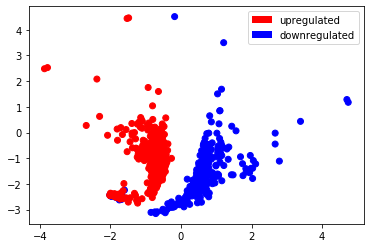

In [3]:
%matplotlib inline
z_run = rvagene.transform(train_dataset)

fig = plt.figure()
ax1 = fig.add_subplot(111)


cols = ['r' if i[0]==0 else 'b' if i[0] == 1 else 'g' for i in y_train[:]]


ax1.scatter(z_run[:,0],z_run[:,1], c=cols[:z_run[:,0].shape[0]])

legend = dict()
legend['upregulated'] = "r"
legend['downregulated'] = "b"
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=legend[i],
                         label=str(i)) for i in legend.keys() ]
ax1.legend(handles=legend_elements)
plt.show()